# Training Notebook

In [1]:
class FishCounter(object):
    import cv2
    def __init__(self,model_config,model_weights):
        self.net = cv2.dnn.readNetFromDarknet(model_config, model_weights)
        self.input_width = 416
        self.input_height = 416

    def inference(self,frame):
        """Run inference on single frame."""
        # Create a 4D blob from a frame.
        blob = cv2.dnn.blobFromImage(
            frame, 1 / 255, (self.input_width, self.input_height), [0, 0, 0], 1, crop=False
        )

        # Sets the input to the network
        self.net.setInput(blob)

        # Runs the forward pass to get output of the output layers
        outs = self.net.forward(self._get_outputs_names(net=self.net))

    def _get_outputs_names(net):
        """Get the names of the output layers."""
        # Get the names of all the layers in the network
        layersNames = net.getLayerNames()
        # Get the names of the output layers, i.e. the layers with unconnected outputs
        return [layersNames[i - 1] for i in net.getUnconnectedOutLayers()]

    def annotated_frame(self):
        """Returns main frame with fish highlighted."""
        frame = self.frame.copy()

In [13]:
import glob
import os

import cv2
import xml.etree.ElementTree as ET

import inference_utils

## Displaying in-cell
from IPython.display import Image
import matplotlib.pyplot as plt


#### Set paths

In [3]:
DATA_DIR = os.path.join("..","data","Herring")

TRAINING_DIR = os.path.join(DATA_DIR,"Training","IRWA 2017 (Large+annotations)")
TESTING_DIR = os.path.join(DATA_DIR,"Testing")


os.path.isdir(DATA_DIR) # assertion that we are pointed to correct folder
WEIGHTS_DIR = os.path.join("..","weights_and_config")
HERRING_WEIGHTS = os.path.join(WEIGHTS_DIR,"Herring")

# Load images and annotations
images = glob.glob(os.path.join(TRAINING_DIR,"Batch 1","*.JPG")) + glob.glob(os.path.join(TRAINING_DIR,"Batch 1","*.jpg"))
annotations = glob.glob(os.path.join(TRAINING_DIR,"Batch 1 annotations","*.xml"))
print("{} images. Annotations: {}".format(len(images),len(annotations)))

144 images. Annotations: 108


## Scoring annotations against inference
**Requirements:** 2 folders: 1 with annotations (e.g. XML), 1 with images
* **Steps:**
  * 1) Run loop on images extracting predicted boxes from each image
  * 2) Scan filenames until box is properly extracted
  * 3) **Scoring Method:**
    * For each annotation find closest/any overlapping boxes (scoring the greater of number of either the annotated or predicted set distinctly)
    * Return average IOU for image
    * Return total number of correctly detected fish

In [41]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	print(interArea)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	print(boxAArea)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	print(boxBArea)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	return interArea / float(boxAArea + boxBArea - interArea)



In [44]:
print(boxes[0])
print(annotation_box)

[32, 129, 265, 89]
[84, 170, 165, 193]


In [47]:
annotation_box = [eval(xmins[0]),eval(xmaxs[0]),eval(ymins[0]),eval(ymaxs[0])]

boxA = boxes[0][0],boxes[0][1],boxes[0][2]+boxes[0][0],boxes[0][3]+boxes[0][1]

bb_intersection_over_union(boxA=boxA,boxB=annotation_box)

1968
23940
1968


0.08220551378446116

In [9]:
print(herring_image,boxes)
idx = [i for i in range(len(annotations)) if herring_image.split("/")[-1].split(".")[0] in annotations[i]][0]

print(annotations[idx])
tree = ET.parse(annotations[idx])
root = tree.getroot()

xmins = []
ymins = []
xmaxs = []
ymaxs = []
for o in root.iter("object"):
    if o.find("name").text == 'herring':
        xmins.append(o[4][0].text)
        ymins.append(o[4][1].text)
        xmaxs.append(o[4][2].text)
        ymaxs.append(o[4][3].text)
print(xmins,xmaxs,ymins,ymaxs)
eval(xmins[0])

../data/Herring/Training/IRWA 2017 (Large+annotations)/Batch 1/2_2017-04-11_08-51-53_large.jpg [[32, 129, 265, 89]]
../data/Herring/Training/IRWA 2017 (Large+annotations)/Batch 1 annotations/2_2017-04-11_08-51-53_large.xml
['84'] ['170'] ['165'] ['193']


84

In [45]:
# boxes.append([left, top, width, height])

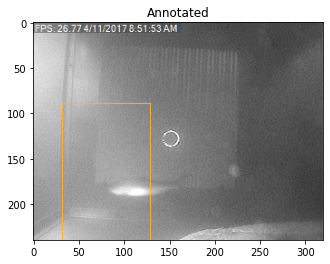

In [27]:
import matplotlib.pyplot as plt

img_path = herring_image
img_name = img_path.split("/")[-1].split(".")[0]
frame = cv2.imread(img_path)

xmin,xmax,ymin,ymax = eval(xmins[0]),eval(xmaxs[0]),eval(ymins[0]),eval(ymaxs[0]) # Annotated
# xmin,xmax,ymin,ymax = boxes[0][0],boxes[0][1],boxes[0][2],boxes[0][3] # Predicted
cv2.rectangle(frame, (xmin, ymin), (xmax,ymax), (255, 178, 50), 1)
cv2.imshow(img_name, frame)
#cv2.putText(img=frame,text=count_label,org=(right + 20, top + 50),fontFace=cv.FONT_HERSHEY_SIMPLEX,fontScale=1.75,color=(255, 255, 255),thickness=1,)
plt.imshow(frame)
plt.title('Annotated')
plt.show()

## Evaluation

In [7]:

## Initialize the parameters
# Confidence threshold
conf_threshold = 0.5
# Non-maximum suppression threshold (maximum bounding box)
nms_threshold = 0.05
input_width = 416 # Width of network's input image
input_height = 416  # Height of network's input image

# Load class name
classes = "Herring"
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = os.path.join(HERRING_WEIGHTS,"herring.cfg")
modelWeights = os.path.join(HERRING_WEIGHTS,"herring_final.weights") 
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)

for a in annotations:
    name = a.split("/")[-1].split(".")[0]

    for herring_image in images:

        if name not in herring_image:
            continue

        print(herring_image)
        frame = cv2.imread(herring_image)
        
        # # Get frame from the video
        # hasFrame, frame = cap.read()

        input_width,input_height,_ = frame.shape
        input_width = input_height = min(input_width,input_height)
        input_width = 416  # Width of network's input image
        input_height = 416  # Height of network's input image

        print(input_height,input_width)
        # Create a 4D blob from a frame.
        blob = cv2.dnn.blobFromImage(
            frame, 1 / 255, (input_width, input_height), [0, 0, 0], 1, crop=False
        )
        
        # Sets the input to the network
        net.setInput(blob)

        # Runs the forward pass to get output of the output layers
        outs = net.forward(inference_utils.get_outputs_names(net=net))
        #break
        # Remove the bounding boxes with low confidence
        counts, boxes = inference_utils.postprocess(
            frame=frame,
            outs=outs,
            tracker=None,
            conf_threshold=conf_threshold,
            nms_threshold=nms_threshold,
            classes=classes,
        )

        print(boxes)
        # cv2.imshow(herring_image, frame)
        # cv2.waitKey(0)
        print("Counts:",counts)
        print()
    cv2.destroyAllWindows()

../data/Herring/Training/IRWA 2017 (Large+annotations)/Batch 1/2_2017-04-16_15-30-08_large.jpg
416 416
BOXES [] () []
counts 0
[]
Counts: 0

../data/Herring/Training/IRWA 2017 (Large+annotations)/Batch 1/2_2017-04-14_11-42-13_large.jpg
416 416
[0.32865852 0.6587873  0.30487534 0.20038645 0.8971311  0.8971311 ]
BOXES [[56, 134, 97, 48]] [0] [0]
counts 1
[[56, 134, 97, 48]]
Counts: 1

../data/Herring/Training/IRWA 2017 (Large+annotations)/Batch 1/2_2017-04-14_10-51-06_large.jpg
416 416
[0.1878179  0.57741845 0.33692092 0.23485109 0.91039896 0.91039896]
BOXES [[6, 110, 107, 56]] [0] [0]
counts 1
[[6, 110, 107, 56]]
Counts: 1

../data/Herring/Training/IRWA 2017 (Large+annotations)/Batch 1/2_2017-04-16_15-18-09_large.jpg
416 416
BOXES [] () []
counts 0
[]
Counts: 0

../data/Herring/Training/IRWA 2017 (Large+annotations)/Batch 1/2_2017-04-14_11-30-46_large.jpg
416 416
[0.3371907  0.57600754 0.24674599 0.17456466 0.8827041  0.8827041 ]
BOXES [[68, 117, 78, 41]] [0] [0]
counts 1
[[68, 117, 78,

KeyboardInterrupt: 